## 5.4 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

In [42]:
import numpy as numpy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from sklearn import datasets
import numpy as np

%matplotlib inline

In [12]:
# boston 데이터셋 로드
X, y = datasets.fetch_openml('boston', return_X_y=True)

bostonDF = X
bostonDF["PRICE"] = y
bostonDF["RAD"] = bostonDF.RAD.astype("int")
print("Boston 데이터셋 크기 : ", bostonDF.shape)
bostonDF.head()

Boston 데이터셋 크기 :  (506, 14)


c:\Users\sybae\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:303: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1.
  warn(
c:\Users\sybae\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


- 각 컬럼별로 주택가격에 미치는 영향도를 조사

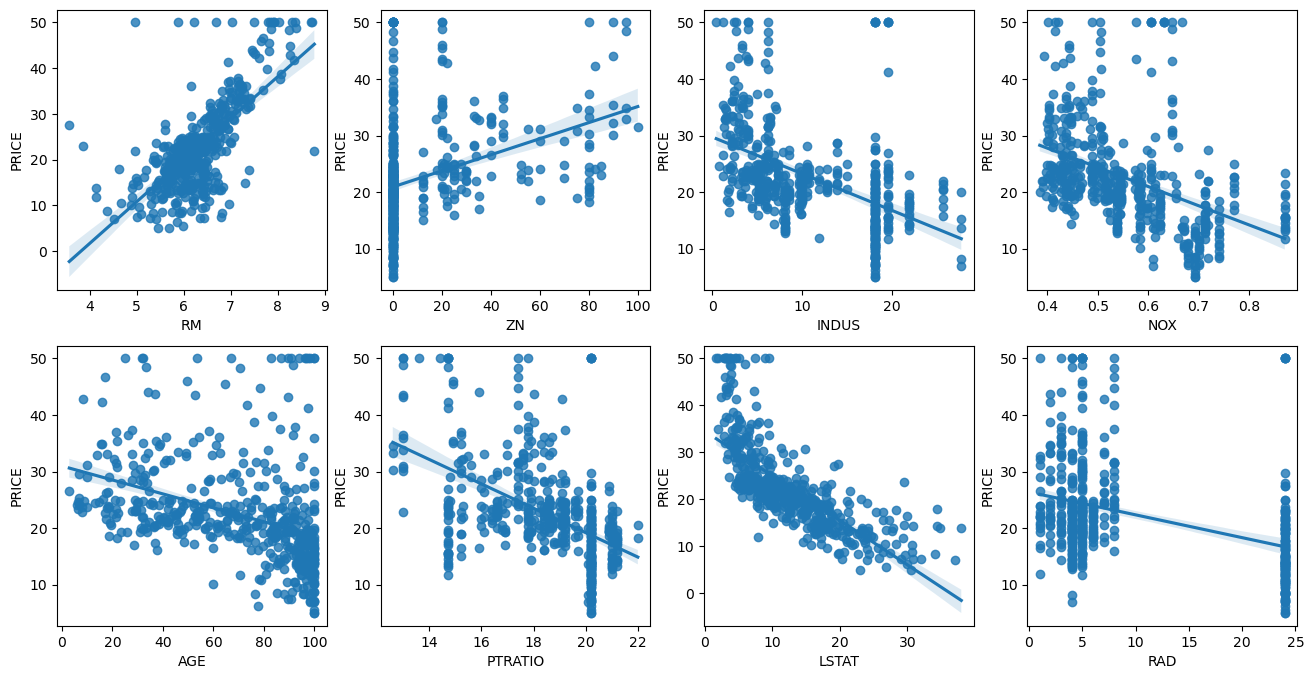

In [22]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4X2개의 ax를 가짐
fig, axs = plt.subplots(figsize = (16, 8), ncols =4, nrows = 2)
lm_features = ["RM", 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4

    # seaborn의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x = feature, y = 'PRICE', data = bostonDF, ax = axs[row][col])

**학습과 테스트 데이터 세트로 분리하고 학습/예측/평가 수행**

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF["PRICE"]
X_data = bostonDF.drop(["PRICE"], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state = 156)

# Linear Regression OLS로 학습/예측/평가 수행.
# linear Regression 예측의 경우 X_train을 array 형식으로 변경해줘야 함.
lr = LinearRegression()
lr.fit(np.array(X_train), np.array(y_train))
y_preds = lr.predict(np.array(X_test))
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print(f"MSE : {round(mse,3)}, RMSE : {round(rmse, 3)}")
print(f"Variance Score : {round(r2_score(y_test, y_preds),3)}")

MSE : 17.297, RMSE : 4.159
Variance Score : 0.757


In [40]:
# 절편과 회귀 계수 값
print("절편 값 : ", lr.intercept_)
print("회귀 계수 값 : ", np.round(lr.coef_,1))

절편 값 :  40.99559517216419
회귀 계수 값 :  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [44]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 SEries로 생성. index가 컬럼명에 유의
coeff = pd.Series(data = np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending = False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [54]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF["PRICE"]
X_data = bostonDF.drop(["PRICE"], axis = 1, inplace = False)
lr = LinearRegression()

# cross_val_score( )로 5 Fold 셋으로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함.
neg_mse_scores = cross_val_score(lr, np.array(X_data), y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring = "neg_mean_squared_error")로 반환된 값은 모두 음수
print(f"5 folds의 개별 Negative MSE scores : {np.round(neg_mse_scores, 2)}")
print(f"5 folds의 개별 RMSE score : {np.round(rmse_scores, 2)}")
print(f"5 folds의 평균 RMSE : {round(avg_rmse,3)}")

5 folds의 개별 Negative MSE scores : [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE score : [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE : 5.829
